In [8]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from timedelay import TimeDelay

We'll work with my favorite star which shows a nice time delay signal; `KIC9651065`. I've set up two different ways for you to load data into the module:

In [4]:
# Method 1. Reading in your own lightcurve and passing it into TimeDelay.
# The data should be in the form `time` (usually days) and `magnitudes`
times, mags = np.loadtxt('C:/Users/Daniel/Desktop/lc_final/appended_8,9/kic9651065_appended-msMAP_Q99_llc.txt', usecols=(0,1)).T
td = TimeDelay(times, mags)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.102851
  Number of iterations: 9
  Number of functions evaluations: 17


In [13]:
# Method 2. Using the module to download a target star photometry from the MAST archives.
# This will only really work with Kepler stars.
td = TimeDelay.from_archive(9651065)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.086510
  Number of iterations: 10
  Number of functions evaluations: 18


Note the tensorflow Optimization messages! The module will automatically try and determine the pulsation frequencies most likely belonging to a delta scuti using Google's TensorFlow library. If you're having troubles with TensorFlow, you can pass `tflow=False` into the TimeDelay module to use a more basic peak fitting method. Be warned though, the frequencies are a bit less accurate without it. 

You can check which frequencies TimeDelay thinks are the most appropriate by calling `td.freqs`

In [16]:
td.freqs

array([19.47767525, 21.71213332, 30.80189357, 17.69941468, 22.69429279,
       24.45638372])

If you have your own frequencies you want to use instead of automatic ones, you can pass them in with the `freqs` keyword:

In [6]:
td = TimeDelay(times, mags, freqs=[19.477])

But for now we'll use the automatically determined frequencies. Let's also check that the lightcurve looks normal before we do anything else.

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.102851
  Number of iterations: 9
  Number of functions evaluations: 17


Text(0,0.5,'Magnitude [mag]')

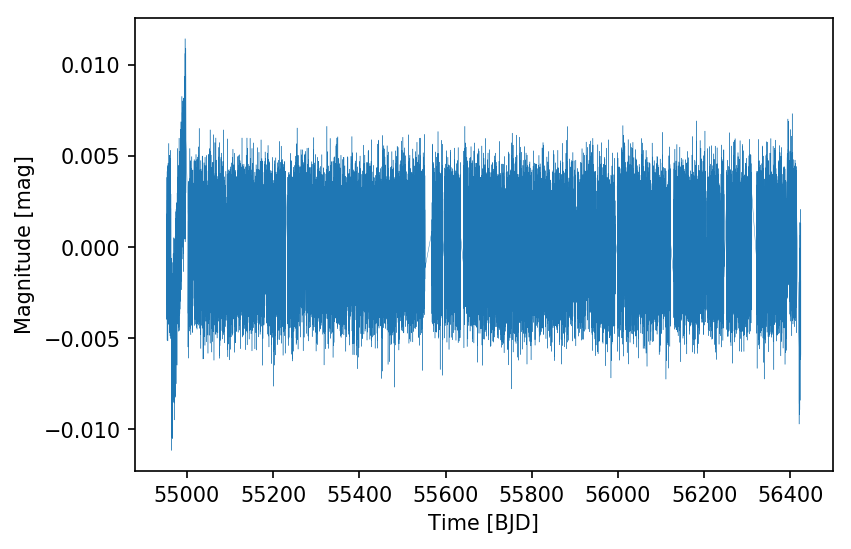

In [9]:
td = TimeDelay(times, mags)

plt.plot(td.times, td.mags, linewidth=0.2)
plt.xlabel('Time [BJD]')
plt.ylabel('Magnitude [mag]')

We should also check out the periodogram to see if the frequencies correspond to appropriate peaks. The pulsations we're really after are p-modes in delta scutis, which normally lie above 5 cycles per day.

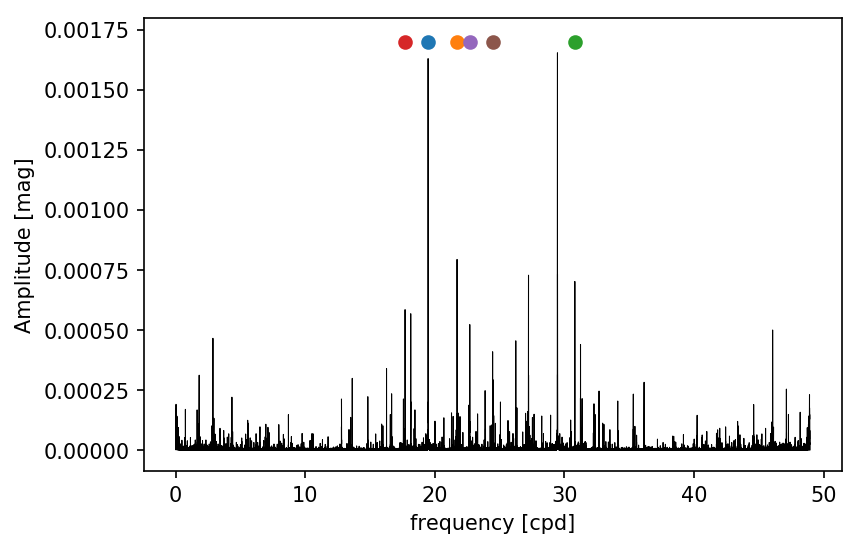

In [10]:
fig, ax = plt.subplots()

# Plots the periodogram
td.plot_periodogram(ax=ax)

# Loop over each frequency and overplot on the periodogram
for freq in td.freqs:
    ax.scatter(freq,0.0017)

Looks good! To get the actual time delay signal you have two options. You can either call `plot_td` which will make a nice plot of the time delays for you, or you can ask just request the values by themselves. 

To calculate the time delays, the lightcurve is split up into several chunks of width `segment_size` $\delta t$ (in units of `times`). For each pulsation mode $\nu$ in each time chunk $t$, the phase $\phi$ of the signal is calculated by a discrete fourier transform $F$:

$$ \phi(t,\nu) = tan^{-1}(\dfrac{Imag(F(t;\nu,\delta t))}{Real(F(t;\nu,\delta t))}) $$

The phase is then converted into a time delay signal by the angular frequency of the pulsation mode

$$ \tau(t) = \dfrac{\Delta \phi(t)}{2 \pi \nu} $$

where $\Delta \phi = \phi(t) - <\phi(t)> $ which sets the average time delay to 0.

I usually pick a segment size around $10$ days, but it's always good to check out how the segment size changes the signal.

Here's what the time delay looks like for a $10$ d segment size:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F6D214588>,
      dtype=object)

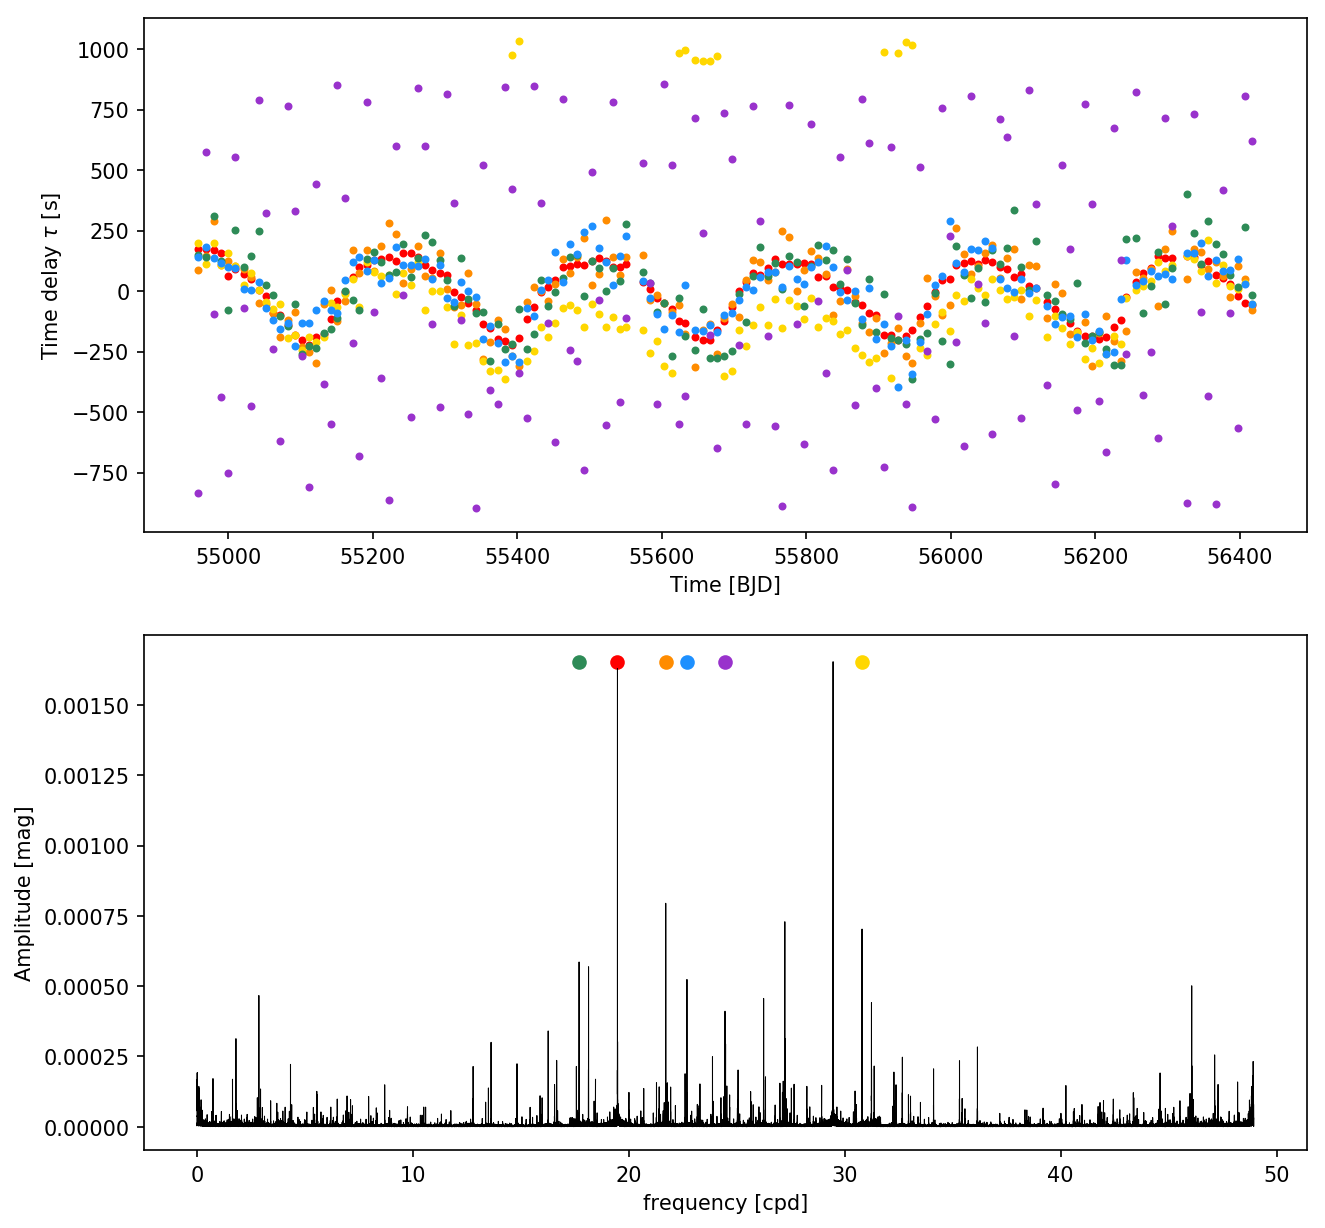

In [11]:
td.plot_td(periodogram=True)

There's a nice clean time delay signal for several of the frequencies in `KIC9651065`. The colours on the periodogram are the pulsation modes corresponding to the time delay plot.

If you simply want the time delays without any plotting, you can call `time_delay`. `time_midpoints` are the mean values in each segmented section of the lightcurve, and `time_delays` are the corresponding signal. There will be `n` arrays in each returned value for `n` frequencies in the model.

In [14]:
time_midpoints, time_delays = td.time_delay(segment_size=10)

There're lots of things you can do with this time delay signal (such as taking the fourier transform of it to find the period of the system), but i'll leave those to you :-)